In [2]:
import pandas as pd
import numpy as np
import glob
import os
from importlib import reload
import nbimporter
from collections import Counter
import functions_readbedfiles, functions_plot
from functions_plot import create_data_traintest, create_data4T_SNE
from functions_readbedfiles import readJsonFile, readFiles2Vector, writeJsonFile, convertMat2document, readJsonFile
import time
import copy
import gc
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import f1_score
from representations_regionset2vec import document_embedding_avg
from sklearn.preprocessing import MinMaxScaler

Importing Jupyter notebook from representations_regionset2vec.ipynb


In [3]:
def initialization(clas_type, label, path_train, path_test, path_universe, meta_data, sample_of_interest, path_w2v_model):
    path_train = path_train.format(clas_type)
    path_test = path_test.format(clas_type)
    path_universe = path_universe.format(clas_type)
    meta_data = pd.read_csv(meta_data.format(clas_type))
    meta_data = meta_data.loc[meta_data[label].isin(sample_of_interest)][['Experiment_ID', label]]
    model = Word2Vec.load(path_w2v_model.format(clas_type))  
    return path_train, path_test, path_universe, meta_data, model

# Select peaks

In [1]:
label = 'cell line'
clas_type = 'cell'
subset = ['train', 'test']

path = '$path_datasets'
path_train = path + 'datasets/{}dataset/{}/*'.format(clas_type, subset[0])

for Q in ([25, 50, 75]):
    path_output = './peaks/{}/{}/Q{}/'.format(clas_type, subset, Q)
    try: 
        os.makedirs(path_output, exist_ok = False) 
        print("Directory '%s' created successfully" % path_output) 
    except OSError as error: 
        print("Directory '%s' can not be created" % path_output) 

for file in glob.glob(path_train):
    df = pd.read_csv(file, sep = '\t', header = None)
    for Q in ([95]):
        path_output = './peaks/{}/{}/Q{}/'.format(clas_type, subset, Q)
        df[df[6]> (np.percentile(df[6], Q))].to_csv(path_output + file.split('/')[-1], sep = '\t', header = None, index = None)

# Classification Performance on selected-peak dataset

In [ ]:
PCA_flg = True

for Q in [25, 50, 75]:
    print('Q: ',Q)
    path_ailist = './AIList/bin/ailist'
    path_peaks = '$path_selected_peaks_datasets'
    path_train = path_peaks + '{}/train/Q{}/*'.format(clas_type, Q)
    path_test = path_peaks + '{}/test/Q{}/*'.format(clas_type, Q)
    path_universe = './representations/{}/'
    meta_data = './meta_data/meta_data_{}.csv'
    path_w2v_model = 'word2vecmodels/word2vec_{}.model'
    path_train, path_test, path_universe, meta_data, model = initialization(clas_type, label, path_train, path_test, path_universe, meta_data, sample_of_interest[i], path_w2v_model)


    for path_univ in sorted(glob.glob(path_universe + "*")):
        print(path_univ)
        gc.collect()
        pca = PCA(n_components= 100)
        train_files , segmentation_df_train = readFiles2Vector(path_ailist, path_train, path_univ, numberofCores = 10, numOfFiles= 100, PATH = path_train)
        test_files, segmentation_df_test = readFiles2Vector(path_ailist, path_test, path_univ, numberofCores = 10, numOfFiles= 100, PATH = path_test)

        X_train, y_train = create_data4T_SNE(train_files, (meta_data.loc[(meta_data[label] !='none') & (meta_data[label] !='nan') & (meta_data[label].notna())]), label, 0, 'Experiment_ID')
        X_test, y_test = create_data4T_SNE(test_files, (meta_data.loc[(meta_data[label] !='none') & (meta_data[label] !='nan') & (meta_data[label].notna())]), label, 0, 'Experiment_ID')
        print(len(X_train[0]), len(X_test[0]))
        if(PCA_flg == True):
            pca.fit(X_train)
            X_train= pca.transform(X_train)
            X_test = pca.transform(X_test)

        clf = svm.SVC(kernel = 'linear')
        clf.fit(X_train, y_train)
        
        print('f1_micro', f1_score((y_test), clf.predict(X_test), average = 'micro'))

    document_Embedding_train = convertMat2document(train_files, segmentation_df_train)
    document_Embedding_avg_train = document_embedding_avg(document_Embedding_train, model)


    document_Embedding_test = convertMat2document(test_files, segmentation_df_test)
    document_Embedding_avg_test = document_embedding_avg(document_Embedding_test, model)


    X_train, y_train = create_data4T_SNE(document_Embedding_avg_train, (meta_data.loc[(meta_data[label] !='none') & (meta_data[label] !='nan') & (meta_data[label].notna())]), label, 0, 'Experiment_ID')
    X_test, y_test = create_data4T_SNE(document_Embedding_avg_test, (meta_data.loc[(meta_data[label] !='none') & (meta_data[label] !='nan') & (meta_data[label].notna())]), label, 0, 'Experiment_ID')

    clf = svm.SVC(kernel = 'linear')
    clf.fit((X_train), y_train)
    print('region-embedding')
    print('f1_micro', f1_score((y_test), clf.predict(X_test), average = 'micro'))


# Similarity detection 

In [ ]:
sim = {}

# Main dataset including all peaks
path = '/project/shefflab/www/papers/region_embedding/'
path_ailist = './AIList/bin/ailist'
path_train = path + 'datasets/{}dataset/train/*'
path_test = path + 'datasets/{}dataset/test/*'
path_universe = './representations/{}/'
meta_data = './meta_data/meta_data_{}.csv'
path_w2v_model = path + 'word2vecmodels/word2vec_{}.model'
path_train, path_test, path_universe, meta_data, model = initialization(clas_type, label, path_train, path_test, path_universe, meta_data, sample_of_interest[i], path_w2v_model)
    
# 
for path_univ in sorted(glob.glob(path_universe + "*"))[-1:]:
    path = '/project/shefflab/www/papers/region_embedding/'
    path_train = path + 'datasets/{}dataset/train/*'
    path_test = path + 'datasets/{}dataset/test/*'
    path_universe = './representations/{}/'
    meta_data = './meta_data/meta_data_{}.csv'
    path_w2v_model = path + 'word2vecmodels/word2vec_{}.model'
    path_train, path_test, path_universe, meta_data, model = initialization(clas_type, label, path_train, path_test, path_universe, meta_data, sample_of_interest[i], path_w2v_model)
    sim_univ = []
    gc.collect()
    pca = PCA(n_components= 100)
    
    train_files , segmentation_df_train = readFiles2Vector(path_ailist, path_train, path_univ, numberofCores = 2, numOfFiles= 100, PATH = path_train)

    gc.collect()
    X_train_Q4, y_train_Q4 = create_data4T_SNE(train_files, (meta_data.loc[(meta_data[label] !='none') & (meta_data[label] !='nan') & (meta_data[label].notna())]), label, 0, 'Experiment_ID')
    X_train_Q4 = pca.fit_transform(X_train_Q4)
  
    segmentation_df_train = None
    train_files = None


#         X_test, y_test = create_data4T_SNE(test_files, (meta_data.loc[(meta_data[label] !='none') & (meta_data[label] !='nan') & (meta_data[label].notna())]), label, 0, 'Experiment_ID')
    print(len(X_train_Q4[0]), len(y_train_Q4[0]))
    

    for Q in [25, 50, 75]:
        print('Q: ',Q)
        path = '/project/shefflab/www/papers/region_embedding/'
        path_peaks = $path_selected_peaks_datasets
        path_train = path_peaks + '{}/train/Q{}/*'.format(clas_type, Q)
        path_test = path_peaks + '{}/test/Q{}/*'.format(clas_type, Q)
        path_universe = './representations/{}/'
        meta_data = './meta_data/meta_data_{}.csv'
        path_w2v_model = path + 'word2vecmodels/word2vec_{}.model'
        path_train, path_test, path_universe, meta_data, model = initialization(clas_type, label, path_train, path_test, path_universe, meta_data, sample_of_interest[i], path_w2v_model)

        
        gc.collect()
        
        train_files , segmentation_df_train = readFiles2Vector(path_ailist, path_train, path_univ, numberofCores = 2, numOfFiles= 100, PATH = path_train)
        gc.collect()
        X_train, y_train = create_data4T_SNE(train_files, (meta_data.loc[(meta_data[label] !='none') & (meta_data[label] !='nan') & (meta_data[label].notna())]), label, 0, 'Experiment_ID')
        pca = PCA(n_components= 100)
    
        segmentation_df_train = None
        train_files = None
        X_train = pca.fit_transform(X_train)
       
        for file in y_train:
            s = cosine_similarity(X_train[y_train.index(file)].reshape(1, -1), X_train_Q4[y_train_Q4.index(file)].reshape(1, -1))
        #     print(s)
            sim_univ.append(s[0][0])
    
        sim[path_univ.split('/')[-1] +'_' + str(Q)] = sim_univ
    



In [ ]:
sim = {}
path = '/project/shefflab/www/papers/region_embedding/'
path_ailist = './AIList/bin/ailist'
path_train = path + 'datasets/{}dataset/train/*'
path_test = path + 'datasets/{}dataset/test/*'
path_universe = './representations/{}/'
meta_data = './meta_data/meta_data_{}.csv'
path_w2v_model = path + 'word2vecmodels/word2vec_{}.model'
path_train, path_test, path_universe, meta_data, model = initialization(clas_type, label, path_train, path_test, path_universe, meta_data, sample_of_interest[i], path_w2v_model)
    
    
for path_univ in sorted(glob.glob(path_universe + "*"))[-1:]:
    path = '/project/shefflab/www/papers/region_embedding/'
    path_train = path + 'datasets/{}dataset/train/*'
    path_test = path + 'datasets/{}dataset/test/*'
    path_universe = './representations/{}/'
    meta_data = './meta_data/meta_data_{}.csv'
    path_w2v_model = path + 'word2vecmodels/word2vec_{}.model'
    path_train, path_test, path_universe, meta_data, model = initialization(clas_type, label, path_train, path_test, path_universe, meta_data, sample_of_interest[i], path_w2v_model)
    sim_univ = []
    gc.collect()
    pca = PCA(n_components= 100)
    
    train_files , segmentation_df_train = readFiles2Vector(path_ailist, path_train, path_univ, numberofCores = 2, numOfFiles= 100, PATH = path_train)
    document_Embedding_train = convertMat2document(train_files, segmentation_df_train)
    
    document_Embedding_avg_train = document_embedding_avg(document_Embedding_train, model)

    X_train_Q4, y_train_Q4 = create_data4T_SNE(document_Embedding_avg_train, (meta_data.loc[(meta_data[label] !='none') & (meta_data[label] !='nan') & (meta_data[label].notna())]), label, 0, 'Experiment_ID')
    X_train_Q4 = pca.fit_transform(X_train_Q4)

    for Q in [25, 50, 75]:
        print('Q: ',Q)
        path = '/project/shefflab/www/papers/region_embedding/'
        path_ailist = '/home/eg8qe/Desktop/NLP-genomic/Code/'
        path_peaks = '/project/shefflab/data/ChIP-Atlas/peaks/'
        path_train = path_peaks + '{}/train/Q{}/*'.format(clas_type, Q)
        path_test = path_peaks + '{}/test/Q{}/*'.format(clas_type, Q)
        path_universe = './representations/{}/'
        meta_data = './meta_data/meta_data_{}.csv'
        path_w2v_model = path + 'word2vecmodels/word2vec_{}.model'
        path_train, path_test, path_universe, meta_data, model = initialization(clas_type, label, path_train, path_test, path_universe, meta_data, sample_of_interest[i], path_w2v_model)

        
        gc.collect()
        
        train_files , segmentation_df_train = readFiles2Vector(path_ailist, path_train, path_univ, numberofCores = 2, numOfFiles= 100, PATH = path_train)
        document_Embedding_train = convertMat2document(train_files, segmentation_df_train)
        
        document_Embedding_avg_train = document_embedding_avg(document_Embedding_train, model)
        
        X_train, y_train = create_data4T_SNE(document_Embedding_avg_train, (meta_data.loc[(meta_data[label] !='none') & (meta_data[label] !='nan') & (meta_data[label].notna())]), label, 0, 'Experiment_ID')
        
        
        document_Embedding_avg_train = None
        pca = PCA(n_components= 100)
        
        X_train = pca.fit_transform(X_train)
        
        if(len(X_train_Q4) != len(X_train)):
            print(len(X_train_Q4) , len(X_train))
            
        for file in y_train:
            s = cosine_similarity(X_train[y_train.index(file)].reshape(1, -1), X_train_Q4[y_train_Q4.index(file)].reshape(1, -1))
            sim_univ.append(s[0][0])
    

        sim[path_univ.split('/')[-1] +'_' + str(Q)] = sim_univ
    

cell_universe.txt_75
0.5816884015630674
cell_feature_5.0_atlas.bed_75
0.6465089363144901
cell_universe.txt_75
0.9103255100329847


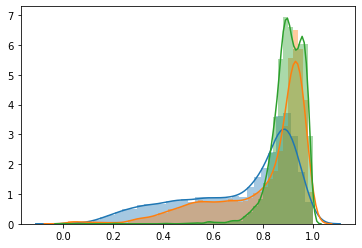

In [21]:
all_data = []
for key, value in list(sim.items()):
    print(key)
#     all_data.extend(np.array(value).reshape(-1, 1))
    x = np.array(value).reshape(-1, 1)
    print(np.mean(x))
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
#     print(max(x))
    ax = sns.distplot(x)
for key, value in sim.items():
    print(key)
    x = np.array(value).reshape(-1, 1)
    print(np.mean(x))
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
#     print(max(x))
    ax = sns.distplot(x)
for key, value in sim.items():
    print(key)
    x = np.array(value).reshape(-1, 1)
    print(np.mean(x))
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)
#     print(max(x))
    ax = sns.distplot(x)